In [12]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
from scipy import stats
# from seaborn import despine
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
plt.rc("axes.spines", top=False, right=False)

from analysis_functions import compute_gaze_influence, sci_notation, run_linear_model, compute_mean_rt, compute_p_choose_best, compute_p_choose_worst, write_summary, make_sure_path_exists

In [13]:
make_sure_path_exists('results/linear_models')

In [14]:
np.random.seed(52) # from random.org

# CP2020 Comparison behaviour and simulations 

## High and Low confidence conditions
----------------

### Load plot function

In [15]:
def plot_correlation(x_in, y,
                     model_names=None,
                     xlabel='',
                     ylabel='',
                     title='',
                     ci=0.95,
                     xticks=None,
                     yticks=None,
                     xticklabels=None,
                     yticklabels=None,
                     xlim=None,
                     ylim=None,
                     annotation_pos=(0.1, 0.1),
                     annotation_halign='left',
                     fontsize_title=15,
                     fontsize_axeslabel=15,
                     fontsize_ticklabels=12,
                     fontsize_annotation=15,
                     plot_diagonal=False,
                     color_code = ['#4F6A9A', '#AC5255'],
                     hatch_code= '',
                     ax=None):
    
    sns.set(style='white', font_scale=1.8)

    x_all = x_in
    # Defaults
    if ax is None:
        fig, ax = plt.subplots()
    if not isinstance(x_in, list):
        x_all = [x_in]
    if not isinstance(y, list):
        y = [y]
    if model_names is None:
        model_names = ['Model {}'.format(i)
                       for i in range(len(y))]
    
    for i, yi in enumerate(y):
        
        # Select if we load the set of observed items for like (0) or dislike (1)
        # This will depend on how we define it later.
        x = x_all[i]

        # LM fit
        X = sm.add_constant(x)
        lm = sm.OLS(yi, X).fit()
        intercept, slope = lm.params
        table, data, columns = summary_table(lm, alpha=1.-ci)
        predicted, mean_ci_lower, mean_ci_upper = data[:, np.array([2, 4, 5])].T

         # Annotation
        tval = lm.tvalues[-1]
        pval = lm.pvalues[-1]
        if pval < 0.01:
            pstring = ' < ' + sci_notation(pval, decimal_digits=2)
        else:
            pstring = ' = {:.2f}'.format(pval)
        r = np.sign(tval) * np.sqrt(lm.rsquared)
        label = ((r'$r = {:.2f}$, '.format(r)) +
                  r'$P${}'.format(pstring))
        xs = np.linspace(*ax.get_xlim(), 100)
        sort_idx = np.argsort(x)
        ax.plot(xs, intercept + slope * xs,
                color=color_code[i], label=label)        
        ax.fill_between(x[sort_idx], mean_ci_lower[sort_idx], mean_ci_upper[sort_idx],
                        color=color_code[i], alpha=0.4, hatch=hatch_code)
        ax.fill_between(x[sort_idx], mean_ci_lower[sort_idx], mean_ci_upper[sort_idx],
                        color='None', alpha=1, hatch=hatch_code, edgecolor="white")
        mpl.rcParams['hatch.linewidth'] = 5  
        
        
        # Scatter
        ax.scatter(x, yi, color=color_code[i], alpha=0.8, s=100,hatch = hatch_code)
        mpl.rcParams['hatch.linewidth'] = 5


    ax.legend(loc='best', fontsize=fontsize_annotation, frameon=False)

    # Axes, ticks, ...
    if xticks is not None:
        ax.set_xticks(xticks)
    if yticks is not None:
        ax.set_yticks(yticks)
        
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels, fontsize=fontsize_ticklabels)
    else :
        ax.tick_params(labelsize=fontsize_ticklabels)

    if yticklabels is not None:
        ax.set_yticklabels(yticklabels, fontsize=fontsize_ticklabels)
    else:
        ax.tick_params(labelsize=fontsize_ticklabels)


    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    # Diagonal
    if plot_diagonal:
        ax.plot([0, 1], [0, 1], transform=ax.transAxes,
                color='black', alpha=.2, zorder=-10, lw=2)

    # Labels
    ax.set_xlabel(xlabel, fontsize=fontsize_axeslabel)
    ax.set_ylabel(ylabel, fontsize=fontsize_axeslabel)
    ax.set_title(title, fontsize=fontsize_title)
    sns.despine()

    return ax

### Load figure function

In [16]:
def figure_correlations(mean_rt, p_choose_best, gaze_influence, figsize=(20, 7), color_code1 = ['#4F6A9A', '#AC5255'], labels = ['Like','Dislike'], model_names1 =['Like', 'Dislike'], hatch2 =''):

    fig, axs = plt.subplots(1, 3, figsize=figsize)

    # PLot legend
    patch1 = mpatches.Patch(facecolor=color_code1[0],hatch=hatch2, label=labels[0],edgecolor="white")
    patch2 = mpatches.Patch(facecolor=color_code1[1],hatch=hatch2, label=labels[1],edgecolor="white")
    mpl.rcParams['hatch.linewidth'] = 2
    leg = plt.legend(handles=[patch1,patch2],fontsize=20,loc = "lower right")
    leg.get_frame().set_facecolor('none')
    leg.get_frame().set_linewidth(0.0)
    plt.gca().add_artist(leg)
      
    fonts_axeslabel = 25 #
    fonts_ticklabels = 20 #
    fonts_title = 25 #
    fonts_annotation = 20 #
    
    plot_correlation([mean_rt['observed_1'].values, mean_rt['observed_2'].values], 
                     [mean_rt['glam_1'].values, mean_rt['glam_2'].values],
                     model_names=model_names1,
                     xlabel='Observed mean RT [ms]',
                     ylabel='GLAM predicted mean RT [ms]',
                     #title='Mean RT (ms)',
                   #  xlim=[1000, 9000],
                   #  ylim=[1000, 9000],
                    # xticks=np.arange(0, 7000, 1000),
                    # yticks=np.arange(0, 7000, 1000),
                     #xticklabels=['0', '', '2000', '', '4000', '', '6000'],
                     #yticklabels=['0', '', '2000', '', '4000', '', '6000'],
                     fontsize_axeslabel=fonts_axeslabel,
                     fontsize_ticklabels=fonts_ticklabels,
                     fontsize_title=fonts_title,
                     fontsize_annotation=fonts_annotation,
                     ax=axs[0], plot_diagonal=True, color_code = color_code1, hatch_code = hatch2 )

    plot_correlation([p_choose_best['observed_1'].values, p_choose_best['observed_2'].values],
                     [p_choose_best['glam_1'].values, p_choose_best['glam_2'].values],
                     model_names=model_names1,
                     xlabel='Observed P(choose correct)',
                     ylabel='GLAM Predicted P(choose correct)',
                  #   title='P(choose best)',
                     xlim=[0.45, 1.],
                     ylim=[0.45, 1.],
                     xticks=np.arange(0.1, 1.1, 0.1),
                     yticks=np.arange(0.1, 1.1, 0.1),
                    # xticklabels=['0.1', '0.2', '0.3','0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'],
                    # yticklabels=['0.1', '0.2', '0.3','0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'],
                     fontsize_axeslabel=fonts_axeslabel,
                     fontsize_ticklabels=fonts_ticklabels,
                     fontsize_title=fonts_title,
                     fontsize_annotation=fonts_annotation,
                     ax=axs[1], plot_diagonal=True, color_code = color_code1,hatch_code = hatch2)

    plot_correlation([gaze_influence['observed_1'].values, gaze_influence['observed_2'].values],
                     [gaze_influence['glam_1'].values, gaze_influence['glam_2'].values],
                     model_names=model_names1,
                     xlabel='Observed gaze influence \non P(Choice|Value)',
                     ylabel='GLAM Predicted gaze influence \non P(Choice|Value)',
                     #title='Gaze influence\non P(choose left)',
                     xticks=np.arange(-0.1, 1, 0.2),
                     yticks=np.arange(-0.1, 1, 0.2),
                     #xticklabels=['-0.1', '0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6'],
                     #yticklabels=['-0.1', '0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6'],
                     #xlim=[-0.125, 0.625],
                     #ylim=[-0.125, 0.625],
                     fontsize_axeslabel=fonts_axeslabel,
                     fontsize_ticklabels=fonts_ticklabels,
                     fontsize_title=fonts_title,
                     fontsize_annotation=fonts_annotation,
                     ax=axs[2], plot_diagonal=True ,color_code = color_code1,hatch_code = hatch2)

    # index axes
 #   for label, ax in zip(list('ABC'), axs.ravel()):
 #       ax.text(-0.1, 1.15, label, transform=ax.transAxes,
 #               fontsize=20, fontweight='bold', va='top')

    fig.tight_layout()

    
    
 

    return None

### Load observed (test) data

In [17]:
def load_test_data(data):
    # Load data
    data = pd.read_csv(data)
    
    # Subset only necessary columns
    data = data[['subject', 'trial', 'choice', 'rt',
             'item_value_0', 'item_value_1',
             'gaze_0', 'gaze_1']]
    data_len = len(data)
    
    data['subject'] = data.replace(data.subject.unique(), list(range(len(data.subject.unique()))))
    
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()
    
    for subject in data.subject.unique():
        subject_data = data[data['subject'] == subject].copy().reset_index(drop=True)
        n_trials = len(subject_data)
        
        #subject_train = subject_data.iloc[np.arange(0, n_trials, 2)].copy()
        subject_test = subject_data.iloc[np.arange(1, n_trials, 2)].copy()
    
        test_data = pd.concat([test_data, subject_test])
        #train_data = pd.concat([train_data, subject_train])
        
    return test_data

def load_train_data(data):
    # Load data
    data = pd.read_csv(data)
    
    # Subset only necessary columns
    data = data[['subject', 'trial', 'choice', 'rt',
             'item_value_0', 'item_value_1',
             'gaze_0', 'gaze_1']]
    data_len = len(data)
    
    data['subject'] = data.replace(data.subject.unique(), list(range(len(data.subject.unique()))))

    
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()
    
    for subject in data.subject.unique():
        subject_data = data[data['subject'] == subject].copy().reset_index(drop=True)
        n_trials = len(subject_data)
        
        subject_train = subject_data.iloc[np.arange(0, n_trials, 2)].copy()
        #subject_test = subject_data.iloc[np.arange(1, n_trials, 2)].copy()
    
        #test_data = pd.concat([test_data, subject_test])
        train_data = pd.concat([train_data, subject_train])
        
    return train_data
    

### Load observed and simulated datasets

## Exp 2 - Free vs Fixed trials

In [18]:
# Free trials
test_data_1 = load_test_data('Data/glam_data/CP2020_GlamData_CP2020_exp2_2ndChoice_Free.csv')
glam_full_1 = pd.read_csv('Results/Predictions/GlamCP2020_indiv_GazeBias_exp2_2ndChoice_Free.csv')

# Fixed trials
test_data_2 = load_test_data('Data/glam_data/CP2020_GlamData_CP2020_exp2_2ndChoice_Fixed.csv')
glam_full_2 = pd.read_csv('Results/Predictions/GlamCP2020_indiv_GazeBias_exp2_2ndChoice_Fixed.csv')


# Plot

In [19]:
mean_rt = pd.DataFrame(dict(observed_1=compute_mean_rt(test_data_1),
                            observed_2=compute_mean_rt(test_data_2),
                            glam_1=compute_mean_rt(glam_full_1),
                            glam_2=compute_mean_rt(glam_full_2)))

p_choose_best = pd.DataFrame(dict(observed_1=compute_p_choose_best(test_data_1),
                                  observed_2=compute_p_choose_best(test_data_2),
                                  glam_1=compute_p_choose_best(glam_full_1),
                                  glam_2=compute_p_choose_best(glam_full_2)))

gaze_influence = pd.DataFrame(dict(observed_1=compute_gaze_influence(test_data_1),
                                   observed_2=compute_gaze_influence(test_data_2),
                                   glam_1=compute_gaze_influence(glam_full_1),
                                   glam_2=compute_gaze_influence(glam_full_2)))

In [20]:
# if remove participants that have problems with convergence in both scenarios
#mean_rt = mean_rt.drop([1,2,5,8])
#p_choose_best = p_choose_best.drop([1,2,5,8])
#gaze_influence = gaze_influence.drop([1,2,5,8])

In [21]:
gaze_influence

,observed_1,observed_2,glam_1,glam_2
0,0.059642,-0.000920,0.153717,0.059417
1,0.343746,-0.061950,0.019177,0.084215
2,-0.105583,0.063673,0.005772,0.044078
3,0.395282,0.150502,0.299440,0.053217
4,-0.115085,-0.127011,0.044979,0.006602
5,0.003475,-0.162197,0.078261,0.033106
6,0.438815,0.076905,0.382160,-0.020808
7,0.101084,0.114655,0.181852,0.008044
8,0.172860,-0.130238,0.035817,0.061046
9,-0.116268,0.075188,0.013637,0.009202


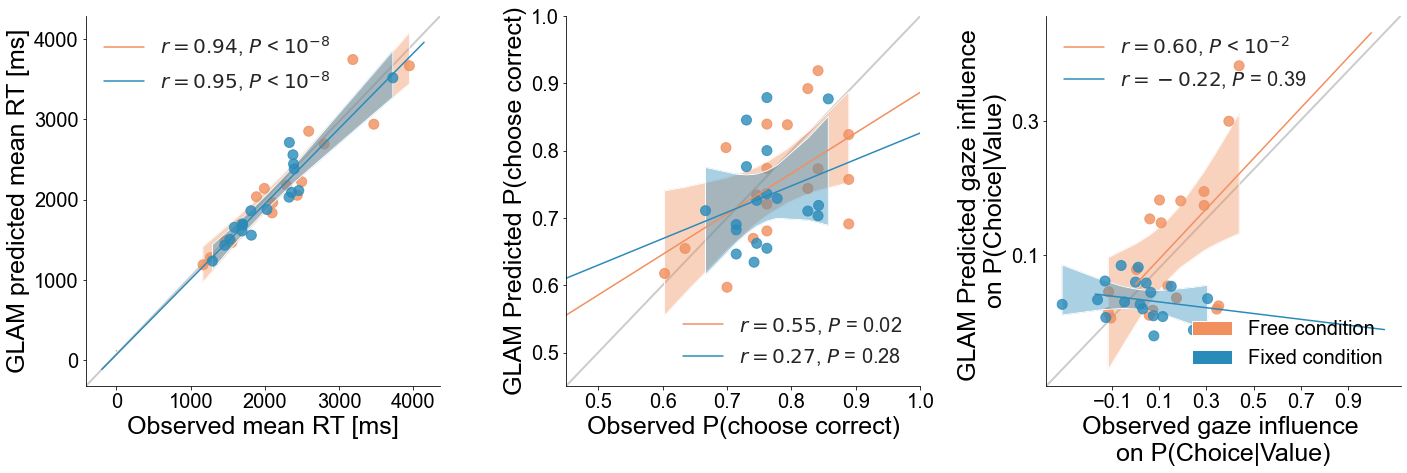

In [22]:
figure_correlations(mean_rt, p_choose_best,gaze_influence,hatch2 ='',labels = ['Free condition','Fixed condition'],color_code1 = ['#f18f5e', '#2a8bba'])



## difference in observed gaze influence between free and fixed trials at participant level

In [23]:
print(' Gaze influence observed/ free-fixed : mean free:' + str(np.mean(gaze_influence['observed_1']))+' SD: '+ str(np.std(gaze_influence['observed_1']))+'; mean fixed: '+ str(np.mean(gaze_influence['observed_2']))+' SD:' + str(np.std(gaze_influence['observed_2']))+ '/ t-test : ' + str(stats.ttest_rel( gaze_influence['observed_1'],gaze_influence['observed_2'])))
print('Abs(Gaze influence observed)/ free-fixed : ' + str(stats.ttest_rel(np.abs(gaze_influence['observed_1']),np.abs(gaze_influence['observed_2']))))


 Gaze influence observed/ free-fixed : mean free:0.14863757069256872 SD: 0.16973419153213248; mean fixed: 0.01620426068721217 SD:0.14256567959395391/ t-test : Ttest_relResult(statistic=2.707950252175956, pvalue=0.014925190782153697)
Abs(Gaze influence observed)/ free-fixed : Ttest_relResult(statistic=1.7926484664444886, pvalue=0.0908417372361447)


## difference in predicted gaze influence between free and fixed trials at participant level

In [24]:
print(' Gaze influence observed/ free-fixed : mean free:' + str(np.mean(gaze_influence['glam_1']))+' SD: '+ str(np.std(gaze_influence['glam_1']))+'; mean fixed: '+ str(np.mean(gaze_influence['glam_2']))+' SD:' + str(np.std(gaze_influence['glam_2']))+ '/ t-test : ' + str(stats.ttest_rel( gaze_influence['glam_1'],gaze_influence['glam_2'])))
print('Abs(Gaze influence observed)/ free-fixed : ' + str(stats.ttest_rel(np.abs(gaze_influence['glam_1']),np.abs(gaze_influence['glam_2']))))


 Gaze influence observed/ free-fixed : mean free:0.1120460081407664 SD: 0.10616468724790394; mean fixed: 0.03346476042351883 SD:0.028592847662080367/ t-test : Ttest_relResult(statistic=2.853245812557612, pvalue=0.010998572937956688)
Abs(Gaze influence observed)/ free-fixed : Ttest_relResult(statistic=2.860990540741426, pvalue=0.010820036561183402)


 ---------------------